### Imports and Constants

In [1]:
import os
import pandas as pd
import random
import ast
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from transformers import AutoConfig, AutoTokenizer, AutoModel, pipeline
from summarizer import Summarizer
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from gensim.summarization import keywords
from IPython.display import Image, display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
summarizer = pipeline("summarization")

In [4]:
FILE_NAME = './results/cluster_results.csv'

CLUSTER_NUMBER = 1

PREV = "Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers"

THERAPEUTIC_1 =  "Effectiveness of drugs being developed and tried to treat COVID-19 patients."
THERAPEUTIC_2 =  "Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication."
THERAPEUTIC_3 = "Capabilities to discover a therapeutic for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents."

VACCINE_1 = "Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients."
VACCINE_2 =  "Exploration of use of best animal models and their predictive value for a human vaccine."
VACCINE_3 =  "Efforts targeted at a universal coronavirus vaccine."
VACCINE_4 =  "Approaches to evaluate risk for enhanced disease after vaccination"
VACCINE_5 =  "Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]"

DISTRIBUTION = "Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need."

QUESTIONS = [PREV, THERAPEUTIC_1, THERAPEUTIC_2, THERAPEUTIC_3, 
             VACCINE_1, VACCINE_2, VACCINE_3, VACCINE_4, VACCINE_5, DISTRIBUTION]

### Import and cleaning data

In [5]:
df = pd.read_csv(FILE_NAME)
df = df.drop(columns=['Unnamed: 0'])

df['disease_on_abstract'] = [ast.literal_eval(a) for a in df['disease_on_abstract']]
df['chemicals_on_abstract'] = [ast.literal_eval(a) for a in df['chemicals_on_abstract']]
df['cluster_vote'] = [ast.literal_eval(a) for a in df['cluster_vote']]

### Display functions

In [6]:
def mask_index(x):
    indexes = []
    for i in range(len(df)):
        if x in df['cluster_vote'][i]:
            indexes.append(i)
    return indexes


def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)


def str_to_date_year(df):
    for i in range(len(df)):
        try:
            df['publish_time'][i] = datetime.datetime.strptime(df['publish_time'][i], "%Y-%m-%d").date().year
        except:
            df['publish_time'][i] = datetime.datetime.strptime(df['publish_time'][i], "%Y").date().year
    
    return df


def df_display(df_cluster, x):
    display(HTML(f'<h2>Articles clustered with question {x} <h2>'))
    temp = df_cluster[['title', 'publish_time', 'authors', 'journal', 'url']]
    display(temp.style.format({'url': make_clickable}))
    
    
def plot_display(df, x):
    df_cluster = df.loc[mask_index(x)]
    display(HTML(f''))
    display(HTML(f'<h2>Cluster Plot into RoBERTa vectors space <h2>'))
    
    plt.figure(figsize=(13, 9))
    plt.scatter(df['tsne_0'], df['tsne_1'], color='lightgrey')
    plt.scatter(df_cluster['tsne_0'], df_cluster['tsne_1'], color='red')
    
    plt.show()
    plt.close()


def wc_display(article):
    c = keywords(article, words=20, lemmatize=True, pos_filter=('NP', 'NN'), scores=True, split=True)

    wordcloud = WordCloud(prefer_horizontal=1.0,
                      width=800,
                      height=300,
                      max_font_size=200,
                      max_words=25,
                      colormap="copper",
                      background_color='white').generate_from_frequencies(dict(c))
    display(HTML(f''))
    display(HTML(f'<h2>Keywords WordCloud<h2>'))
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.close()

    
def NER_display(df_cluster):
    
    disease_flat_list = [item.lower() for sublist in df_cluster['disease_on_abstract'] for item in sublist]
    
    display(HTML(f'<h2>List of Most Commun Diseases Mentioned in those scholars:<h2>'))
    a = [word for word, word_count in Counter(disease_flat_list).most_common(10)]
    
    print(*a, sep = "\n")
    
    chemical_flat_list = [item.lower() for sublist in df_cluster['chemicals_on_abstract'] for item in sublist]

    
    display(HTML(f'<h2>List of Most Commun Chemicals Mentioned in those scholars:<h2>'))
    a = [word for word, word_count in Counter(chemical_flat_list).most_common(10)]
    print(*a, sep = "\n")
            

    
def sum_display(article):
    s = summarizer(article, max_length=300, min_length=200)[0]['summary_text']
    
    display(HTML(f''))
    display(HTML(f'<h2>Summary<h2>'))
    
    display(HTML(f'<p> {s} <p>'))
    
    
def show_articles_cluster_df(x):
    df_cluster = df.loc[mask_index(x)]
    df_display(df_cluster, x)


def show_articles_publication_time(x):
    df_cluster = df.loc[mask_index(x)]
    df_cluster_articles = df_cluster[df_cluster['license']!='question'].reset_index(drop=True)
    df_cluster_articles = str_to_date_year(df_cluster_articles)
    
    labels, values = zip(*OrderedDict(Counter(df_cluster_articles['publish_time'].values).most_common()).items())
    
    display(HTML(f''))
    display(HTML(f'<h2>Number of articles through time<h2>'))
    
    plt.figure(figsize=(10, 3)) 
    ax = plt.subplot(111)
    barlist = ax.bar(labels, values, width=0.5, align='center', tick_label=labels, color='sandybrown')
    if 2020 in labels:
        barlist[0].set_color('saddlebrown')
    plt.xticks(rotation='vertical')
    
    plt.show()
    
def show_articles_cluster_words(x):
    df_cluster = df.loc[mask_index(x)]
    article = '. '.join(df_cluster[df_cluster['license']!='question']['abstract'].values)

    wc_display(article)
    
    NER_display(df_cluster)
    

def show_articles_cluster_sum(x):
    df_cluster = df.loc[mask_index(x)]
    article = '. '.join(df_cluster[df_cluster['license']!='question']['abstract'].values)

    sum_display(article)

In [7]:
# Create text widget for output
output_slider_variable = widgets.Text()

# Define function to bind value of the input to the output variable 
def f(x):
    output_slider_variable.value = str(x)

### Interactive Display

In [23]:
@interact
def show(columns='Question', x=widgets.IntSlider(min=0, max=9, step=1, value=1)):
    
    interact(f, x=fixed(x))

    df_cluster = df.loc[mask_index(x)]

    display(HTML(f'<h2> Question {x}:<h2> {QUESTIONS[x]}'))

interactive(children=(Text(value='Question', description='columns'), IntSlider(value=1, description='x', max=9…

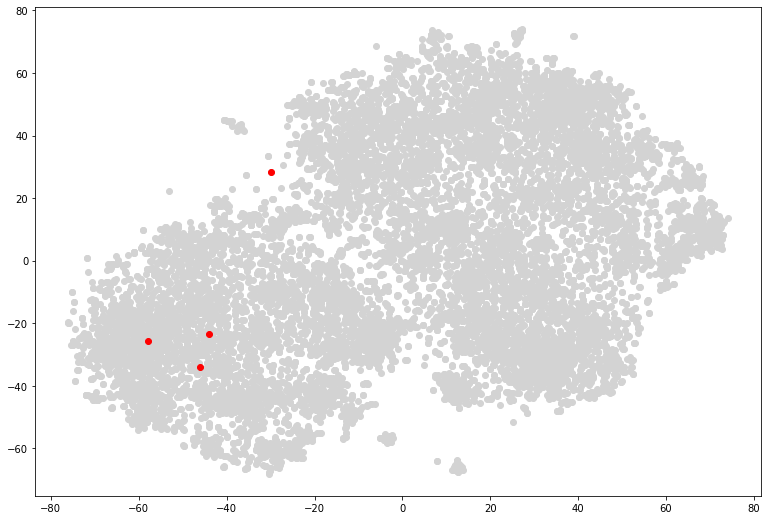

In [24]:
chosen_cluster = int(output_slider_variable.value)
plot_display(df, chosen_cluster)

In [25]:
show_articles_cluster_df(chosen_cluster)

,title,publish_time,authors,journal,url
623,First Discovery and Stucture-Activity Relationship Study of Phenanthroquinolizidines as Novel Antiviral Agents against Tobacco Mosaic Virus (TMV),2012-12-28,"Wang, Ziwen; Feng, Anzheng; Cui, Mingbo; Liu, Yuxiu; Wang, Lizhong; Wang, Qingmin",PLoS One,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3532156/
973,"The Antibody Germline/Maturation Hypothesis, Elicitation of Broadly Neutralizing Antibodies Against HIV-1 and Cord Blood IgM Repertoires",2014-08-28,"Prabakaran, Ponraj; Chen, Weizao; Dimitrov, Dimiter S.",Front Immunol,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4147355/
5561,Flunarizine Prevents Hepatitis C Virus Membrane Fusion in a Genotype-dependent Manner by Targeting the Potential Fusion Peptide within E1,2015-10-09,"Perin, Paula M.; Haid, Sibylle; Brown, Richard J. P.; Doerrbecker, Juliane; Schulze, Kai; Zeilinger, Carsten; von Schaewen, Markus; Heller, Brigitte; Vercauteren, Koen; Luxenburger, Eva; Baktash, Yasmine M.; Vondran, Florian W. R.; Speerstra, Sietkse; Awadh, Abdullah; Mukhtarov, Furkat; Schang, Luis M; Kirschning, Andreas; Müller, Rolf; Guzman, Carlos A.; Kaderali, Lars; Randall, Glenn; Meuleman, Philip; Ploss, Alexander; Pietschmann, Thomas",Hepatology,http://europepmc.org/articles/pmc4688136?pdf=render
13522,Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.,question,kaggle,kaggle,nan


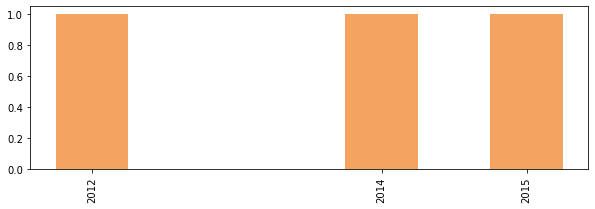

In [26]:
show_articles_publication_time(chosen_cluster)

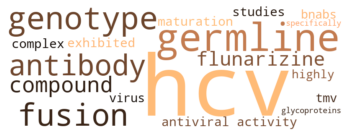

tmv
hiv1
hcv infection


phenanthroquinolizidine alkaloids
flunarizine


In [27]:
show_articles_cluster_words(chosen_cluster)

In [18]:
show_articles_cluster_sum(chosen_cluster)